In [1]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# Константы
API_URL = "http://127.0.0.1:5000/predict"
TEST_DATA_PATH = "../data/test.csv"

In [3]:
def get_xysplit(data_path):
    data = pd.read_csv(data_path)
    X_test = data.drop(columns=["Unnamed: 0", "target"]).replace([np.nan, np.inf, -np.inf], None)
    y_test = data["target"]
    return X_test, y_test

In [4]:
def test_api(X_test, api_url):
    y_pred_proba = []

    print("🚀 Отправка запросов в API...\n")
    for _, row in tqdm(X_test.iterrows(), total=len(X_test), desc="Запросы"):
        json_data = row.to_dict()

        try:
            response = requests.post(api_url, json=json_data, timeout=5)

            if response.status_code == 200:
                result = response.json()

                model_name = result["model_name"] if "model_name" in result else None
                # Проверка на ключ 'prediction'
                if "prediction" in result:
                    y_pred_proba.append(result["prediction"])
                else:
                    print("Ключ 'proba' не найден в ответе, используем 0.0")
                    y_pred_proba.append(0.0)
            else:
                print(f"Ошибка {response.status_code}: {response.text}")
                y_pred_proba.append(0.0)



        except Exception as e:
            print(f"Ошибка запроса: {e}")
            y_pred_proba.append(0.0)

    return y_pred_proba, model_name

In [5]:
def get_rocuac(y_test, y_pred_proba):
    auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    print(f"ROC AUC: {auc:.4f}")
    return auc, fpr, tpr

In [6]:
def get_roc_curve(y_test, y_pred_proba, model_name):
    auc, fpr, tpr = get_rocuac(y_test, y_pred_proba)
    get_graph(auc, tpr, fpr, model_name)

In [7]:
def get_graph(auc, tpr, fpr, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.4f}", color='navy')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC AUC — API with {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../v1/plots/{model_name}_api_roc_auc.png")
    plt.show()

In [8]:
def start_test(data_path=TEST_DATA_PATH, api_url=API_URL, n_rows='all'):
    X_test, y_test = get_xysplit(data_path)

    if n_rows == 'all':
        n_rows = len(y_test)
    elif isinstance(n_rows, int) and n_rows > len(y_test):
        n_rows = len(y_test)

    X_sample = X_test.iloc[:n_rows]
    y_sample = y_test.iloc[:n_rows]

    y_pred_proba, model_name = test_api(X_sample, api_url)

    return y_sample, y_pred_proba, model_name

In [9]:
y_test, y_pred_proba, model_name = start_test(n_rows=1000)

🚀 Отправка запросов в API...



Запросы: 100%|██████████| 1000/1000 [00:22<00:00, 43.58it/s]


ROC AUC: 0.7885


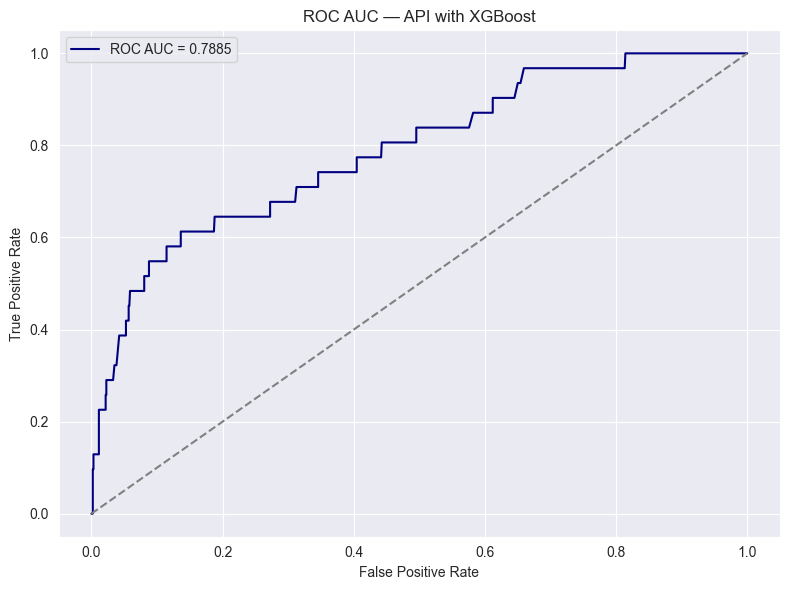

In [10]:
get_roc_curve(y_test, y_pred_proba, model_name)